In [1]:
from sklearn import preprocessing
from scipy import stats
from itertools import chain
from collections import Counter
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import inf

import calendar
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option("display.float_format", lambda x: "{:,.2f}".format(x))
# pd.options.mode.use_inf_as_na = True
pd.set_option("display.max_columns", None)
sns.set(style="ticks")

# plt.style.use("seaborn")
# plt.xkcd()

%matplotlib inline

In [2]:
for i, (x, y) in enumerate(zip(pd.read_csv("data/train.csv").shape, pd.read_csv("data/test.csv").shape)):
    print(x) if x > y else print(y) if i else print(x + y)

7398
23


In [3]:
df = pd.read_csv("data/train.csv").merge(pd.read_csv("data/test.csv"), how="outer")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 7397
Data columns (total 23 columns):
id                       7398 non-null int64
belongs_to_collection    1481 non-null object
budget                   7398 non-null int64
genres                   7375 non-null object
homepage                 2366 non-null object
imdb_id                  7398 non-null object
original_language        7398 non-null object
original_title           7398 non-null object
overview                 7376 non-null object
popularity               7398 non-null float64
poster_path              7396 non-null object
production_companies     6984 non-null object
production_countries     7241 non-null object
release_date             7397 non-null object
runtime                  7392 non-null float64
spoken_languages         7336 non-null object
status                   7396 non-null object
tagline                  5938 non-null object
title                    7395 non-null object
Keywords           

### READ

In [4]:
train_df = pd.read_csv("data/train.csv")

### CLEAN

In [5]:
dictionary_columns = ["belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages", "Keywords", "cast", "crew"]

for column in dictionary_columns:
    train_df[column] = train_df[column].apply(lambda row: ast.literal_eval(row) if not pd.isna(row) else [{"name": "NO DATA"}])
    
train_df["release_date"] = pd.to_datetime(train_df["release_date"])
train_df["release_date"] = train_df["release_date"].apply(lambda row: row - relativedelta(years=100) if row >= datetime.now() else row)

# train_df = train_df[(train_df["budget"] > 0) & (train_df["revenue"] > 0)]
train_df = train_df[(train_df["budget"] >= 15_000) & (train_df["revenue"] >= 100_000)]

### CALCULATE

In [6]:
train_df["roi"] = train_df["revenue"] / train_df["budget"]
train_df["adjusted_roi"] = train_df["revenue"] / (train_df["budget"] * 2)

train_df["release_year"] = train_df["release_date"].map(lambda x: x.year)
train_df["release_month"] = train_df["release_date"].map(lambda x: x.month)
# train_df["release_day"] = train_df["release_date"].map(lambda x: x.day)
train_df["release_day_of_week"] = train_df["release_date"].dt.dayofweek

# min_max_scaler
train_df["normalized_popularity"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["popularity"]).reshape((-1,1)))
train_df["normalized_budget"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["budget"]).reshape((-1,1)))
train_df["normalized_runtime"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["runtime"]).reshape((-1,1)))
train_df["normalized_revenue"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["revenue"]).reshape((-1,1)))
train_df["normalized_roi"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["roi"]).reshape((-1,1)))
train_df["normalized_adjusted_roi"] = preprocessing.MinMaxScaler().fit_transform(np.array(train_df["roi"]).reshape((-1,1)))

### DESCRIBE

In [7]:
train_df.loc[:, train_df.columns != "id"].describe()

,budget,popularity,runtime,revenue,roi,adjusted_roi,release_year,release_month,release_day_of_week,normalized_popularity,normalized_budget,normalized_runtime,normalized_revenue,normalized_roi,normalized_adjusted_roi
count,2.091000e+03,2091.000000,2091.000000,2.091000e+03,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,3.213771e+07,9.960269,110.519847,9.090978e+07,12.545935,6.272967,2000.017217,6.877571,3.220469,0.033830,0.084537,0.326982,0.059764,0.000973,0.000973
std,4.074913e+07,13.996276,22.432759,1.579297e+08,296.055279,148.027640,15.430805,3.408170,1.306840,0.047552,0.107239,0.066369,0.103938,0.022967,0.022967
min,1.500000e+04,0.003013,0.000000,1.006590e+05,0.005165,0.002582,1921.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000e+06,5.671845,96.000000,8.487733e+06,0.882709,0.441354,1994.000000,4.000000,2.000000,0.019260,0.015751,0.284024,0.005520,0.000068,0.000068
50%,1.800000e+07,8.473369,106.000000,3.220403e+07,2.081863,1.040932,2004.000000,7.000000,4.000000,0.028778,0.047331,0.313609,0.021128,0.000161,0.000161
75%,4.000000e+07,11.806200,121.000000,1.030759e+08,4.211848,2.105924,2011.000000,10.000000,4.000000,0.040101,0.105228,0.357988,0.067771,0.000326,0.000326
max,3.800000e+08,294.337037,338.000000,1.519558e+09,12890.386667,6445.193333,2017.000000,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train_df.sort_values(by="budget", ascending=True).head(20)
# train_df["production_companies"][11]
train_df[["title", "budget", "revenue"]]

,title,budget,revenue
0,Hot Tub Time Machine 2,14000000,12314651
1,The Princess Diaries 2: Royal Engagement,40000000,95149435
2,Whiplash,3300000,13092000
3,Kahaani,1200000,16000000
5,Pinocchio and the Emperor of the Night,8000000,3261638
...,...,...,...
2992,The Thief of Bagdad,1135654,1213880
2993,The Terminal,60000000,219417255
2997,The Long Kiss Goodnight,65000000,89456761
2998,Along Came Polly,42000000,171963386


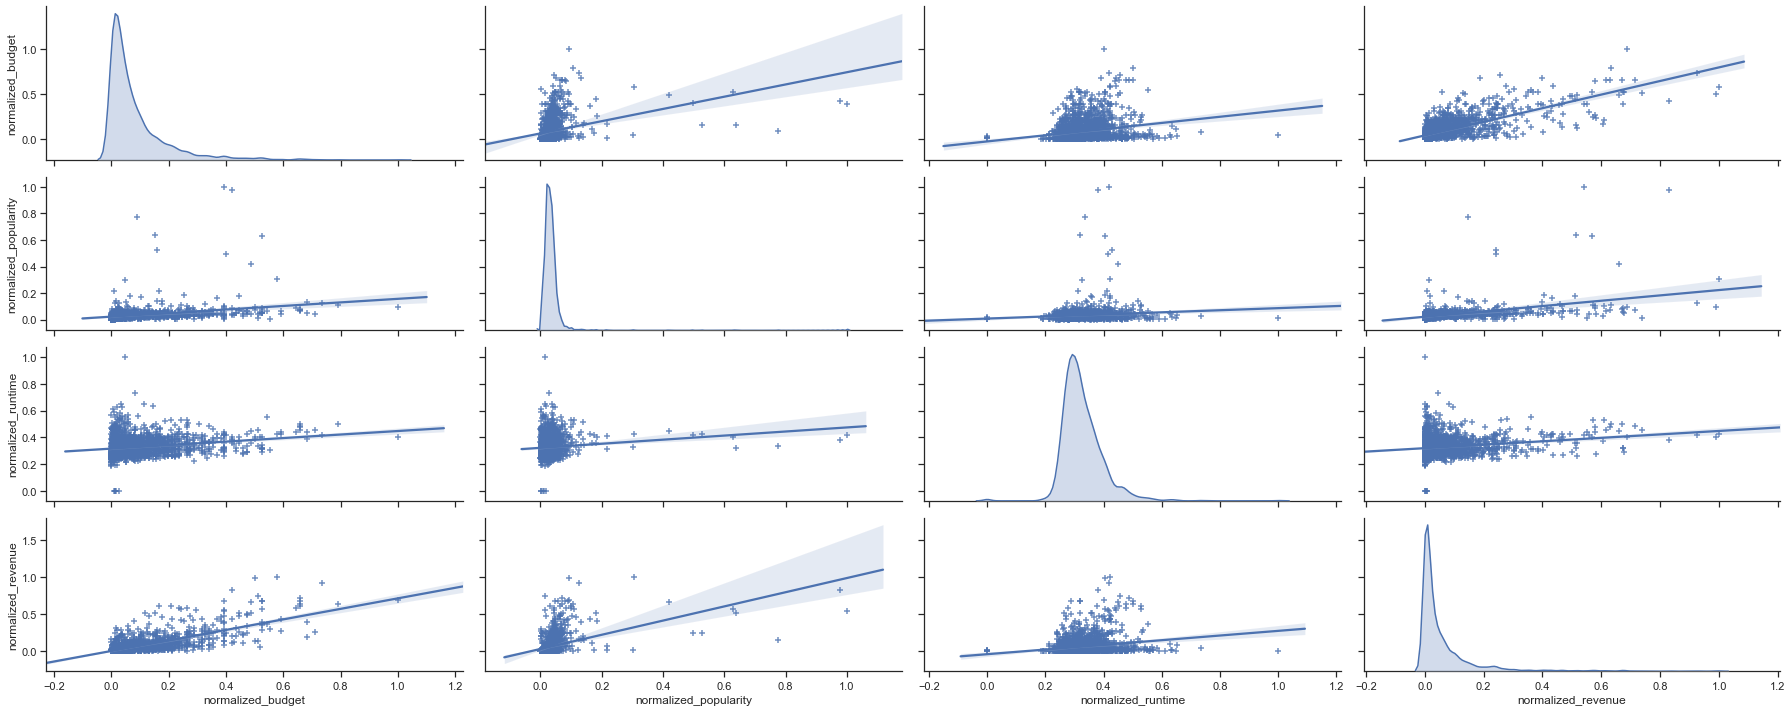

In [9]:
sns.pairplot(train_df[["normalized_budget", "normalized_popularity", "normalized_runtime", "normalized_revenue"]],
             markers="+", diag_kind="kde", kind="reg", aspect=2.5)

# sns.pairplot(train_df[["budget", "popularity", "runtime", "revenue"]],
#              markers="+", diag_kind="kde", kind="reg", aspect=2)

plt.tight_layout()

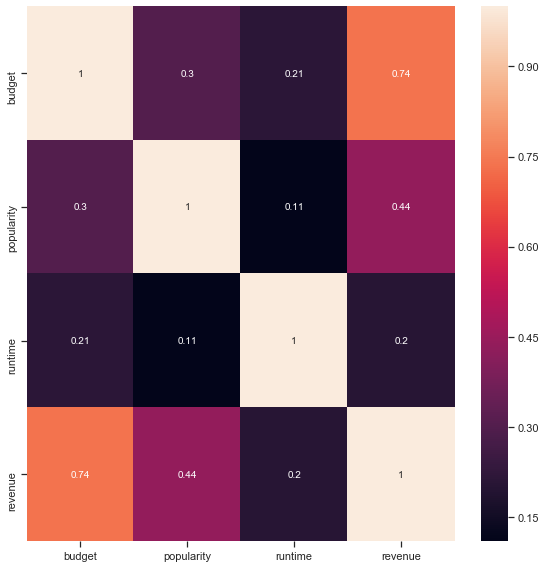

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.heatmap(train_df[["normalized_budget", "normalized_popularity", "normalized_runtime", "normalized_revenue"]].corr(), annot=True)

sns.heatmap(train_df[["budget", "popularity", "runtime", "revenue"]].corr(), annot=True)

plt.tight_layout()

In [11]:
"""
# read
test_df = pd.read_csv("data/test.csv")

# clean
test_df.drop("status", axis=1, inplace=True)
# test_df = test_df[test_df["budget"] >= 15000]

# describe
test_df.describe(include="all")

# test_df.sort_values(by="budget").head(10)
""";

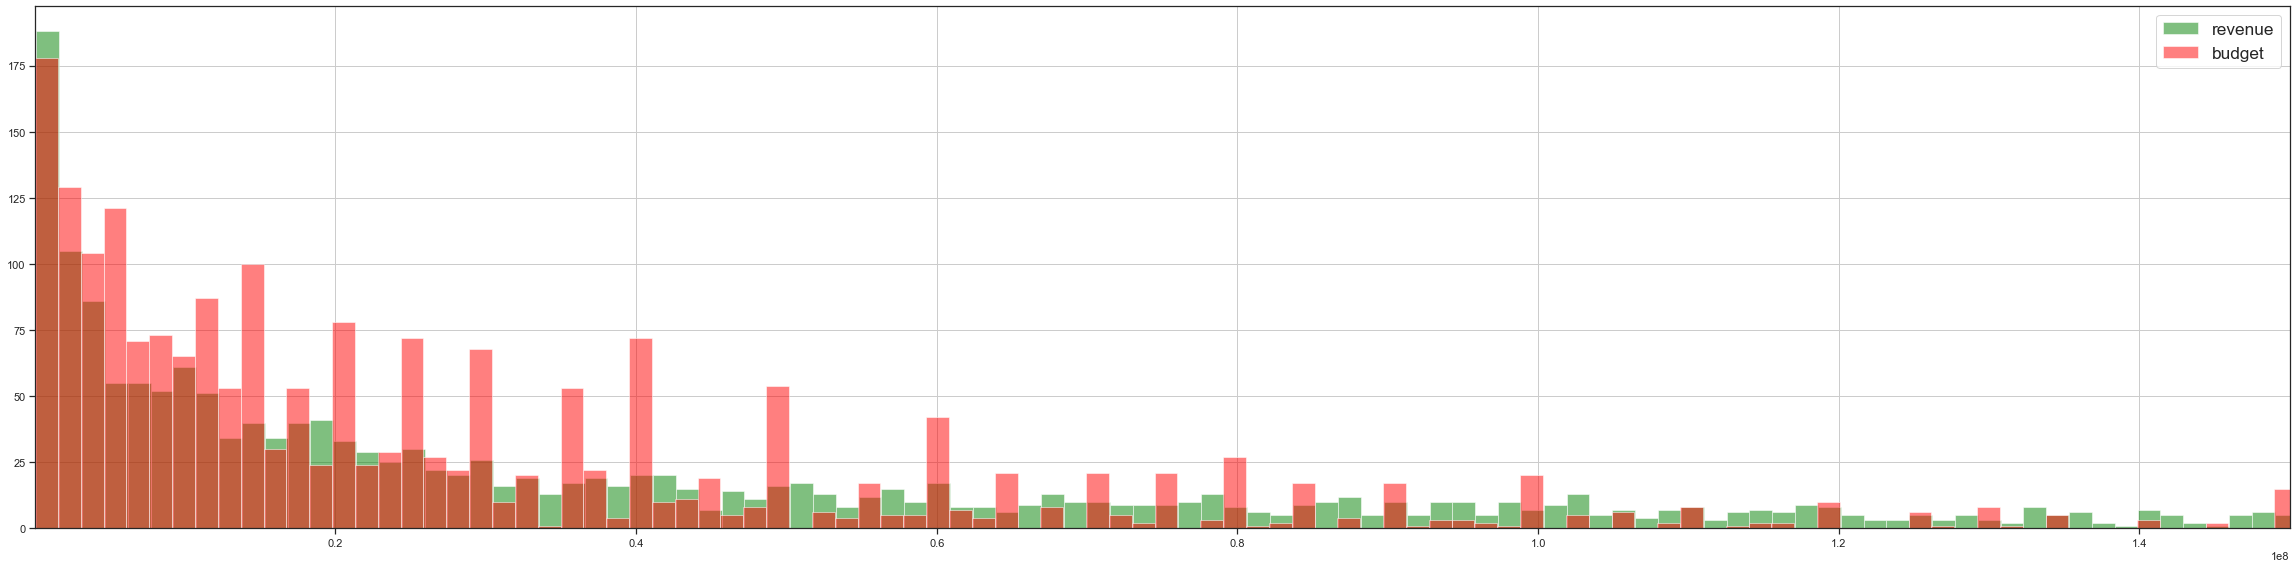

In [12]:
fig, ax = plt.subplots(figsize=(32, 8), sharex=True, sharey=True)

train_df["revenue"].hist(bins=1000, ax=ax, alpha=0.5, color="green")
train_df["budget"].hist(bins=250, ax=ax, alpha=0.5, color="red")

ax.set_xlim((15_000, 150_000_000))
# ax.set_ylim((0, 175))
ax.legend(["revenue", "budget"], fontsize="xx-large")

plt.tight_layout()

In [13]:
# train_df.head()

In [14]:
# lists_of_genres = train_df["genres"].apply(lambda genres: [genre["name"] for genre in genres] if genres else ["no data"])
# Counter(chain(*lists_of_genres)).most_common()

In [15]:
# lists_of_production_companies = train_df["production_companies"].apply(lambda production_companies: [production_company["name"] for production_company in production_companies] if production_companies else ["no data"])
# Counter(chain(*lists_of_production_companies)).most_common(21)

In [16]:
def count_dict_items(df, dct_columns=dictionary_columns):
    top_counts = []
    for column in dct_columns:
        top_count = Counter(chain(*df[column].apply(lambda row: [dct["name"] for dct in row] if row else ["NO DATA"]))).most_common()
        top_counts.append(top_count)
    return pd.DataFrame(top_counts, index=dct_columns).T

In [17]:
# top_counts = count_dict_items(train_df)
# top_counts_df = pd.DataFrame(top_counts, index=dictionary_columns).T

top_counts_df = count_dict_items(train_df)

top_counts_df.head(50)
# top_counts_df["production_companies"].dropna().head(10)

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,Keywords,cast,crew
0,"(NO DATA, 1602)","(Drama, 1031)","(Warner Bros., 170)","(United States of America, 1724)","(English, 1905)","(NO DATA, 123)","(Samuel L. Jackson, 25)","(Robert Rodriguez, 44)"
1,"(James Bond Collection, 16)","(Comedy, 696)","(Universal Pictures, 154)","(United Kingdom, 255)","(Français, 190)","(duringcreditsstinger, 115)","(Robert De Niro, 24)","(Avy Kaufman, 37)"
2,"(Friday the 13th Collection, 7)","(Thriller, 604)","(Paramount Pictures, 132)","(France, 139)","(Español, 180)","(woman director, 99)","(Morgan Freeman, 23)","(James Newton Howard, 36)"
3,"(Rocky Collection, 4)","(Action, 596)","(Twentieth Century Fox Film Corporation, 121)","(Germany, 127)","(Deutsch, 115)","(murder, 96)","(Bruce Willis, 23)","(Francine Maisler, 35)"
4,"(Ice Age Collection, 4)","(Romance, 387)","(Columbia Pictures, 83)","(Canada, 89)","(Pусский, 113)","(based on novel, 91)","(Bruce McGill, 23)","(Deborah Aquila, 35)"
5,"(The Fast and the Furious Collection, 4)","(Adventure, 368)","(New Line Cinema, 68)","(India, 68)","(Italiano, 91)","(independent film, 86)","(J.K. Simmons, 22)","(Steven Spielberg, 33)"
6,"(Rambo Collection, 4)","(Crime, 359)","(Metro-Goldwyn-Mayer (MGM), 63)","(Australia, 46)","(日本語, 60)","(violence, 70)","(Jason Statham, 20)","(Jerry Goldsmith, 33)"
7,"(Alien Collection, 4)","(Science Fiction, 240)","(NO DATA, 57)","(Italy, 41)","(普通话, 52)","(dystopia, 70)","(George Clooney, 20)","(Mary Vernieu, 32)"
8,"(Resident Evil Collection, 4)","(Horror, 231)","(Walt Disney Pictures, 55)","(Russia, 34)","(हिन्दी, 48)","(aftercreditsstinger, 69)","(Forest Whitaker, 20)","(Luc Besson, 31)"
9,"(Child's Play Collection, 4)","(Family, 194)","(Touchstone Pictures, 50)","(Japan, 32)","(, 34)","(sport, 62)","(Sigourney Weaver, 20)","(Tricia Wood, 28)"


In [18]:
# formatted_df = train_df.copy()
# formatted_df["budget"] = formatted_df["budget"].apply("${:,.2f}".format)
# formatted_df["revenue"] = formatted_df["revenue"].apply("${:,.2f}".format)

# formatted_df.sort_values("roi", ascending=False)

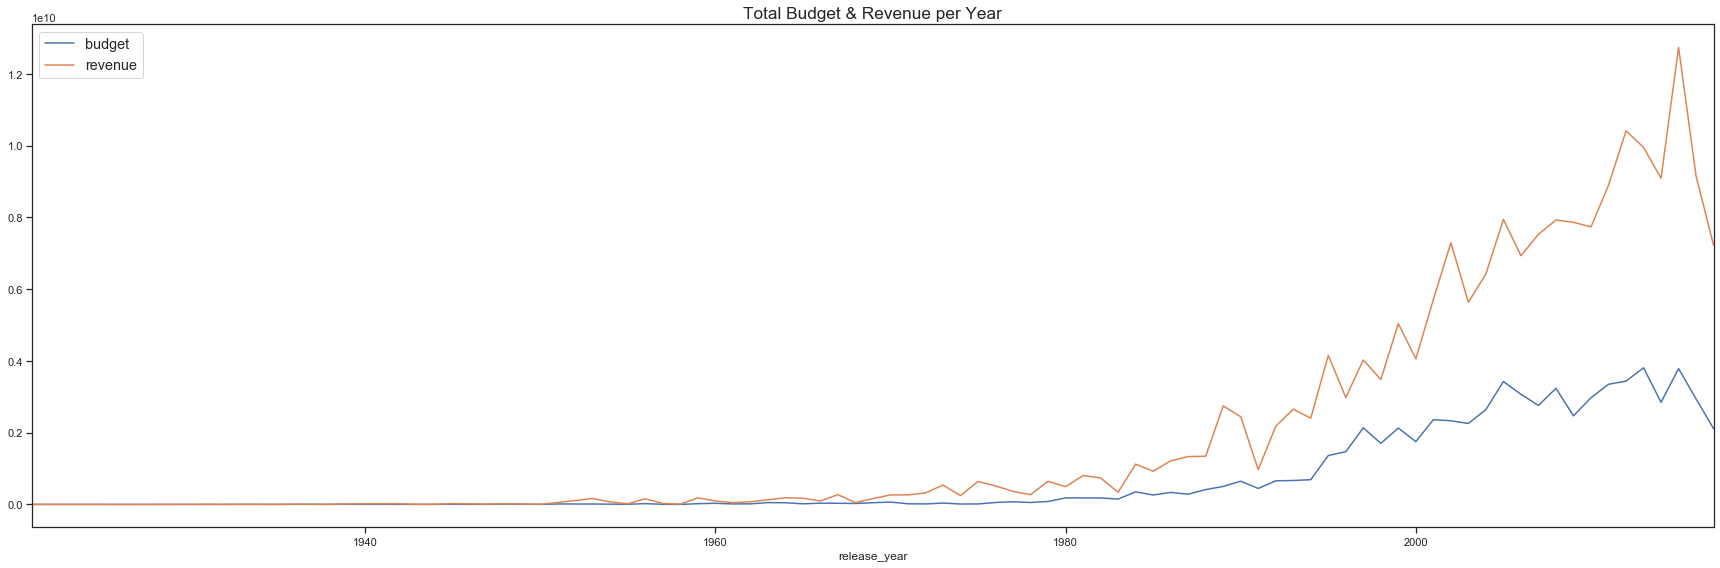

In [19]:
pd.set_option("display.float_format", lambda x: "{:,.2f}".format(x))

fig, ax = plt.subplots(figsize=(24,8))

train_df[["release_year", "budget", "revenue"]].groupby("release_year").sum().plot(ax=ax)

ax.set_title("Total Budget & Revenue per Year", fontsize="xx-large")

ax.legend(fontsize="x-large")

plt.tight_layout()

In [20]:
pd.reset_option("display.float_format")

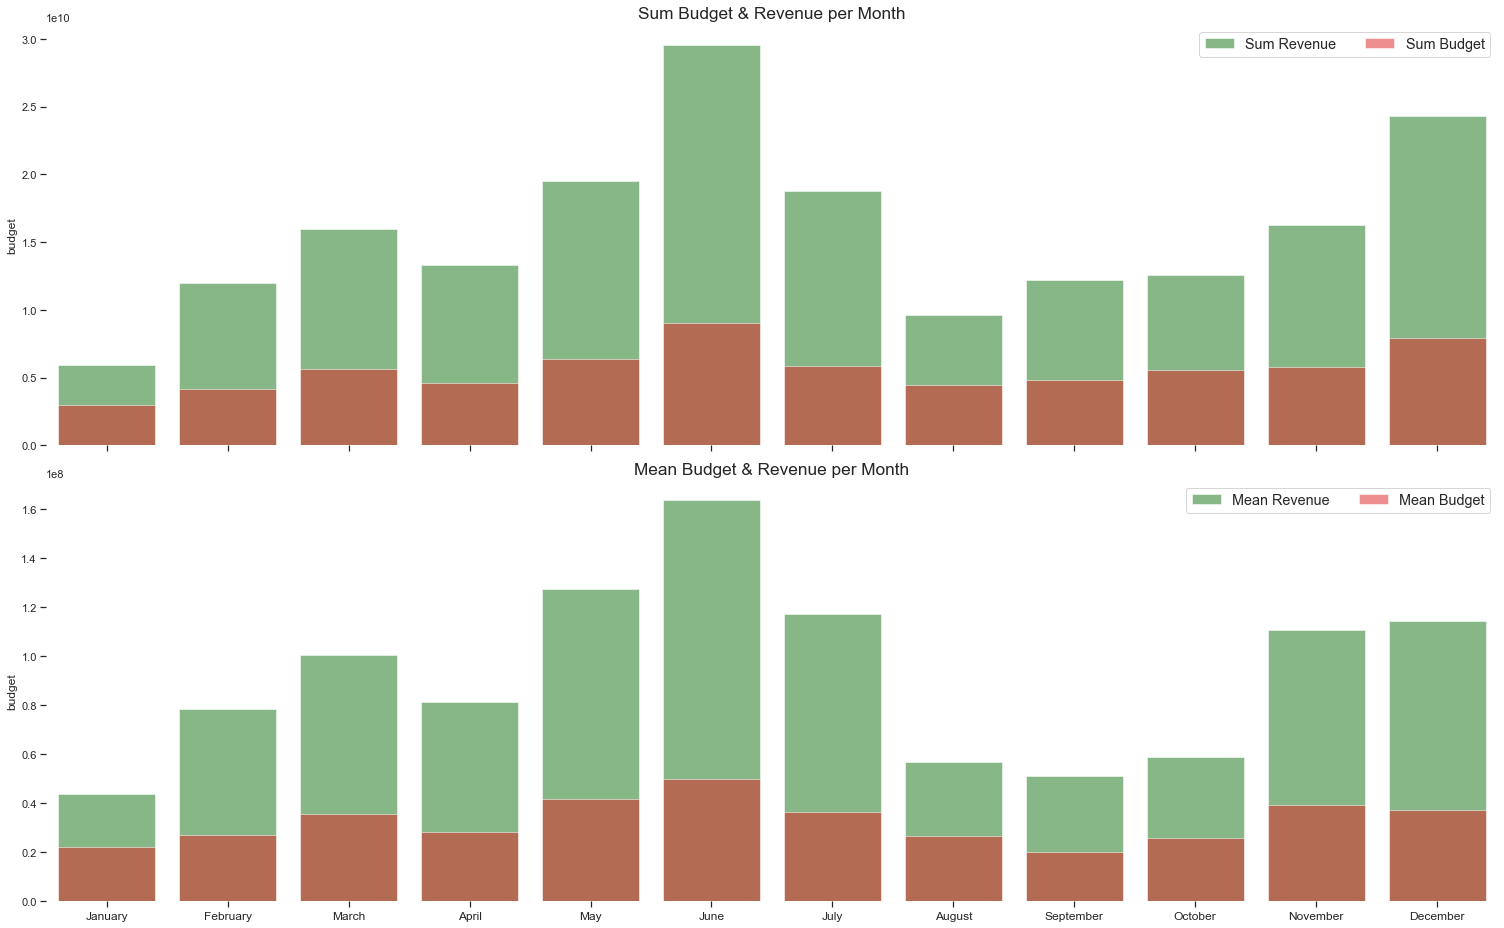

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21,13), sharex=True, sharey=False)

data1 = train_df[["release_month", "budget", "revenue"]].groupby("release_month").sum()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data1, ax=ax1, label="Sum Revenue", color="green", alpha=0.5)

sns.barplot(x=list(range(12)), y="budget", data=data1, ax=ax1, label="Sum Budget", color="red", alpha=0.5)

ax1.set_xticks(range(12))
ax1.set_xticklabels(calendar.month_name[1:], fontsize="large")

ax1.set_title("Sum Budget & Revenue per Month", fontsize="xx-large")

ax1.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

########

data2 = train_df[["release_month", "budget", "revenue"]].groupby("release_month").mean()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data2, ax=ax2, label="Mean Revenue", color="green", alpha=0.5)

# sns.set_color_codes("muted")
sns.barplot(x=list(range(12)), y="budget", data=data2, ax=ax2, label="Mean Budget", color="red", alpha=0.5)

ax2.set_xticks(range(12))
ax2.set_xticklabels(calendar.month_name[1:], fontsize="large")

ax2.set_title("Mean Budget & Revenue per Month", fontsize="xx-large")

ax2.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

plt.tight_layout()

In [22]:
"""
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21,13), sharex=True, sharey=False)

data1 = train_df[["release_day_of_week", "budget", "revenue"]].groupby("release_day_of_week").sum()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data1, ax=ax1, label="Sum Revenue", color="green", alpha=0.5)

sns.barplot(x=list(range(12)), y="budget", data=data1, ax=ax1, label="Sum Budget", color="red", alpha=0.5)

ax1.set_xticks(range(12))
ax1.set_xticklabels(calendar.day_name[1:], fontsize="large")

ax1.set_title("Sum Budget & Revenue per Day", fontsize="xx-large")

ax1.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

########

data2 = train_df[["release_day_of_week", "budget", "revenue"]].groupby("release_day_of_week").mean()

sns.set_color_codes("colorblind")
sns.barplot(x=list(range(12)), y="revenue", data=data2, ax=ax2, label="Mean Revenue", color="green", alpha=0.5)

# sns.set_color_codes("muted")
sns.barplot(x=list(range(12)), y="budget", data=data2, ax=ax2, label="Mean Budget", color="red", alpha=0.5)

ax2.set_xticks(range(12))
ax2.set_xticklabels(calendar.month_name[1:], fontsize="large")

ax2.set_title("Mean Budget & Revenue per Day", fontsize="xx-large")

ax2.legend(ncol=2, frameon=True, fontsize="x-large")
sns.despine(left=True, bottom=True)

plt.tight_layout()
""";

In [23]:
def find_in_movie(row, name):
    """
    input:
        row is a list of dictionaries
        name is a string
    
    output:
        boolean value
    """
    for ele in row:
        if ele["name"].lower() == name.lower():
            return True
    return False

def movie_search(df, name, category):
    """
    input:
        df is a pandas dataframe.
        name is the string to query in the chosen category.
        category is a string of the column name to query.
        categories options include:
            belongs_to_collection
            genres
            production_companies
            production_countries
            spoken_languages
            Keywords
            cast
            crew
    
    output:
        pandas dataframe with filtered search results
    """
    return df[df[category].apply(lambda row: find_in_movie(row, name))]

In [24]:
# movie_search(train_df, "nicolas cage", "cast")[["revenue"]].sum()

# for actor, count in top_counts_df["cast"][:50]:
#     rev = float(movie_search(train_df, actor, "cast")[["revenue"]].sum())
#     bud = float(movie_search(train_df, actor, "cast")[["budget"]].sum())
#     net = rev - bud

In [25]:
def movie_search_aggregate(df, ele, category, agg="sum"):
    """
    helper function for box_office_from_search()
    """
    if agg == "sum":
        budget = float(movie_search(df, ele, category)[["budget"]].sum())
        revenue = float(movie_search(df, ele, category)[["revenue"]].sum())
    elif agg == "mean":
        budget = float(movie_search(df, ele, category)[["budget"]].mean())
        revenue = float(movie_search(df, ele, category)[["revenue"]].mean())
    else:
        return "invalid agg argument"
    return budget, revenue

def box_office_from_search(category, agg="sum", top=21, data_to_find=top_counts_df, df=train_df):
    """
    input:
        category is a string of the column name to query.
        categories options include:
            belongs_to_collection
            genres
            production_companies
            production_countries
            spoken_languages
            Keywords
            cast
            crew
        top is an int of how many elements to iterate over in chosen category.
        data_to_find is the where the search terms come from.
        df is the dataframe being searched.
        
    output:
        names is a list of strings used to search the df.
        budgets is a list of floats.
        revenues is a list of floats.
        nets is a list of revenues minus budgets.
    """
    names = [name for name, count in data_to_find[category][:top]]
    budgets = []
    revenues = []
    nets = []
    
    for ele, count in data_to_find[category][:top]:
        budget, revenue = movie_search_aggregate(df, ele, category, agg)
        net = revenue - budget
        
        budgets.append(budget)
        revenues.append(revenue)
        nets.append(net)
    
    return names, budgets, revenues, nets

In [26]:
def barplot_movies(category, agg, ax, top=21, data_to_find=top_counts_df, df=train_df):
    names, budgets, revenues, nets = box_office_from_search(category, agg=agg, top=top, data_to_find=data_to_find, df=df)
    sns.set_color_codes("colorblind")
    sns.barplot(x=revenues, y=list(range(len(names))), orient="h", ax=ax, label=f"{agg.title()} Revenue", color="green", alpha=0.5)
    sns.barplot(x=budgets, y=list(range(len(names))), orient="h", ax=ax, label=f"{agg.title()} Budget", color="red", alpha=0.5)
    ax.legend(frameon=True, fontsize="large")
    ax.set_yticklabels(names)

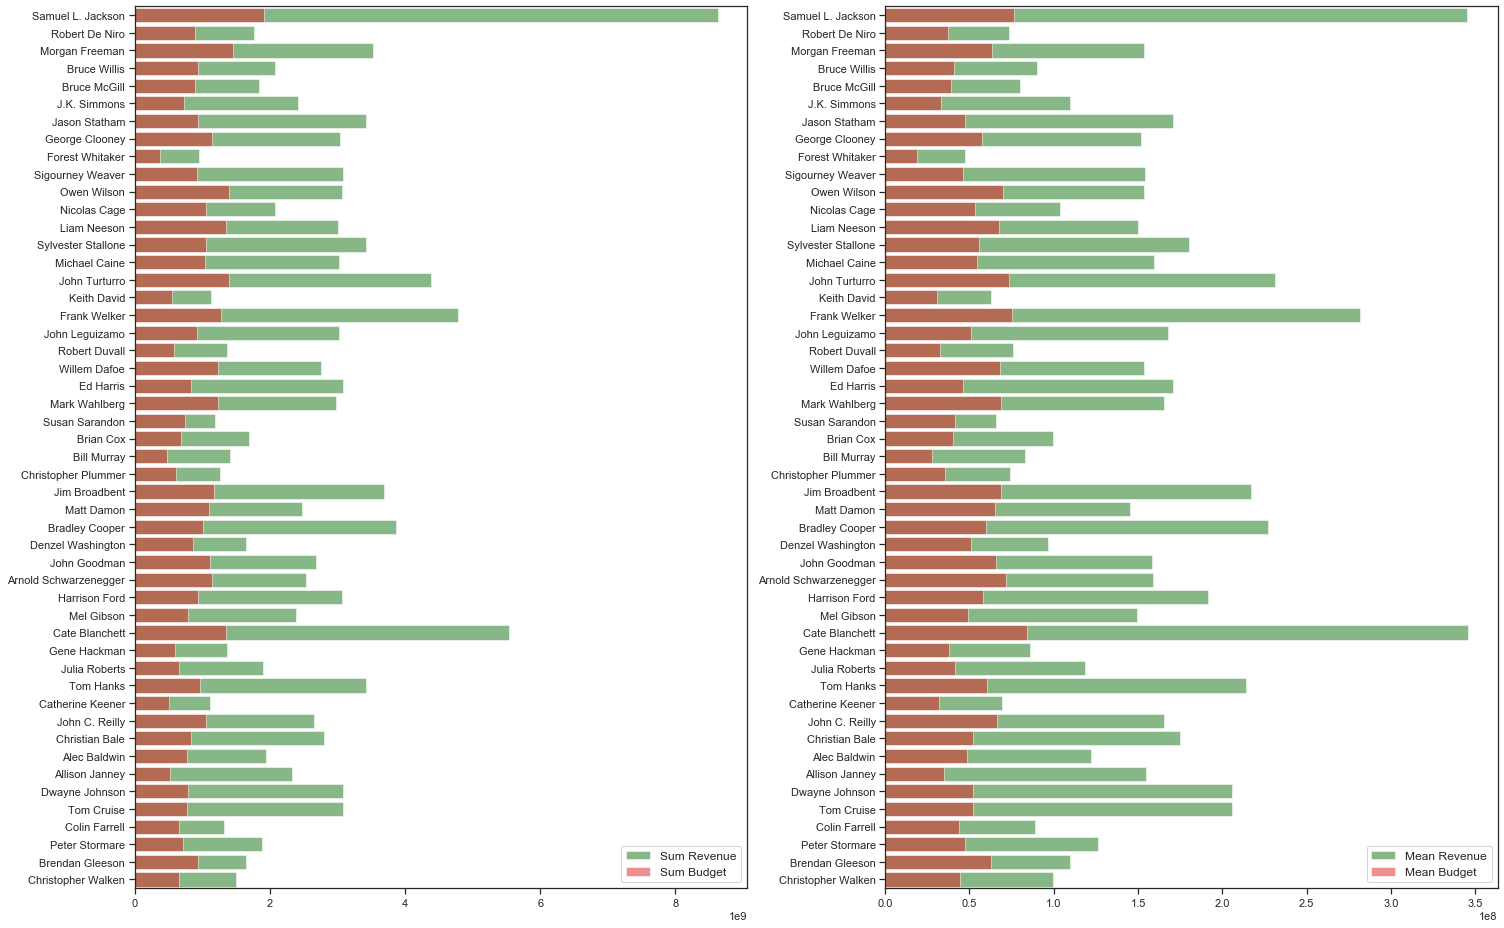

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies("cast", agg="sum", ax=ax1, top=50)

# top_50_actor_names, top_50_actor_budgets, top_50_actor_revenues, top_50_actor_nets = box_office_from_search("cast", top=50)

# sns.set_color_codes("pastel")
# sns.barplot(x=top_50_actor_revenues, y=list(range(50)), orient="h", ax=ax1, color="g", label="Total Revenue")
# sns.set_color_codes("muted")
# sns.barplot(x=top_50_actor_budgets, y=list(range(50)), orient="h", ax=ax1, color="g", label="Total Budget")
# ax1.set_title("Top Credited Cast")
# ax1.set_yticklabels(top_50_actor_names)
# ax1.legend(frameon=True, fontsize="large", loc="lower right")

barplot_movies("cast", agg="mean", ax=ax2, top=50)

plt.tight_layout()

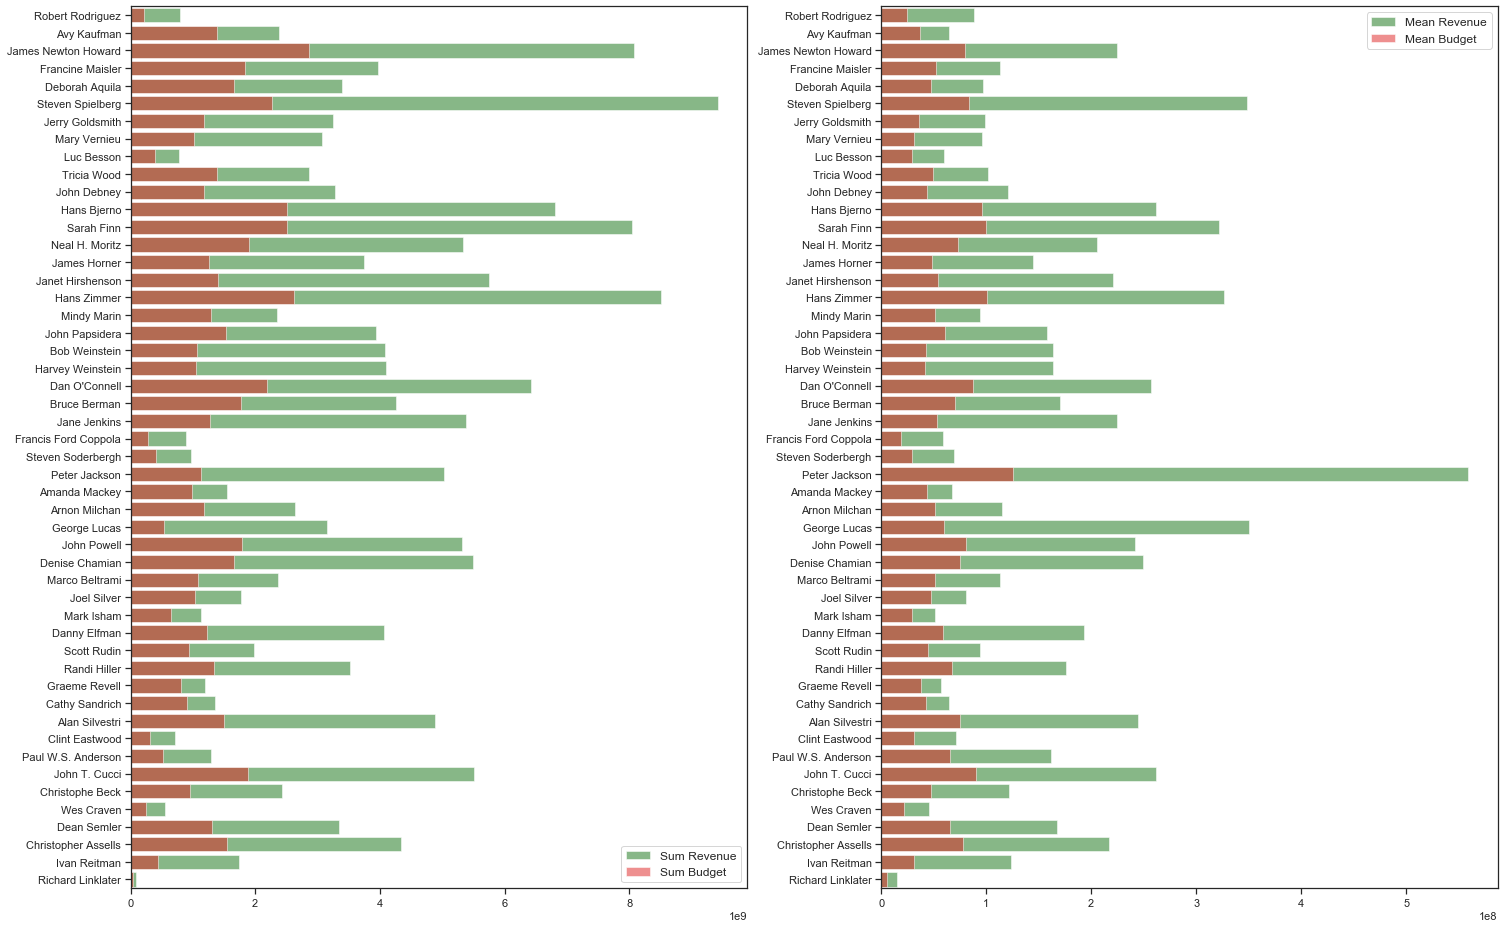

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies("crew", agg="sum", ax=ax1, top=50)
barplot_movies("crew", agg="mean", ax=ax2, top=50)

plt.tight_layout()

# crew_names, crew_budgets, crew_revenues, crew_nets = box_office_from_search("crew", top=50)

# sns.set_color_codes("pastel")
# sns.barplot(x=crew_revenues, y=list(range(50)), orient="h", ax=ax2, color="g", label="Total Revenue")
# sns.set_color_codes("muted")
# sns.barplot(x=crew_budgets, y=list(range(50)), orient="h", ax=ax2, color="g", label="Total Budget")
# ax2.set_yticklabels(crew_names)
# ax2.set_title("Top Credited Crew")
# ax2.legend(frameon=True, fontsize="large", loc="lower right")

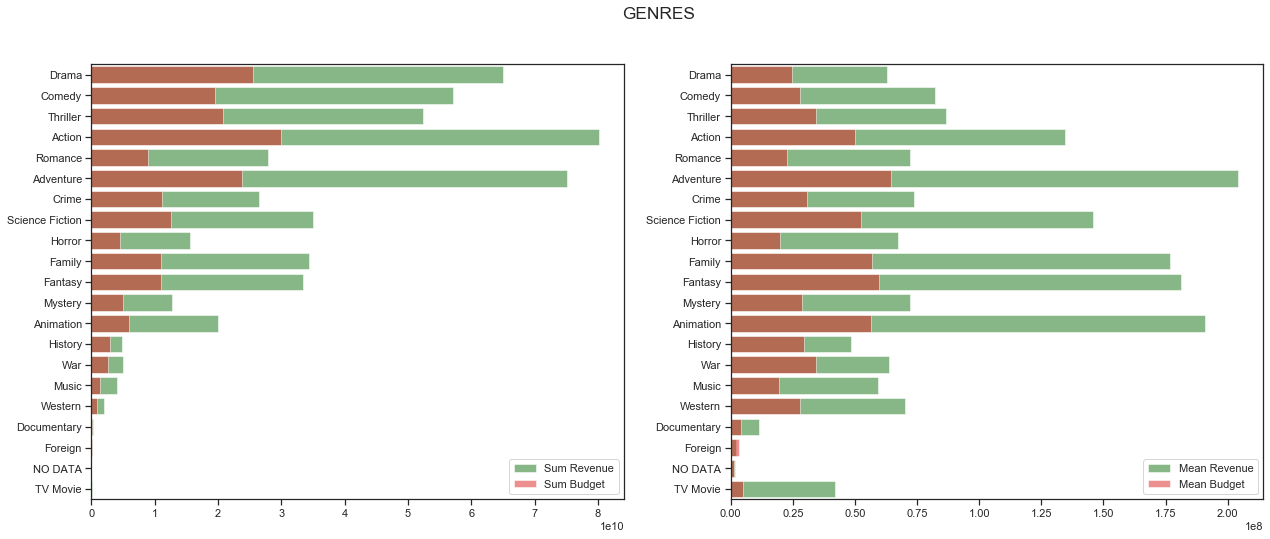

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 8), sharex=False)
ax1, ax2 = axes

# fig, ax = plt.subplots(figsize=(13, 13))

# genre_names, genre_budgets, genre_revenues, genre_nets = box_office_from_search("genres", agg="mean")

# sns.set_color_codes("pastel")
# sns.barplot(x=genre_revenues, y=list(range(len(genre_names))), orient="h", ax=ax, label="Mean Revenue", color="g")
# sns.set_color_codes("muted")
# sns.barplot(x=genre_budgets, y=list(range(len(genre_names))), orient="h", ax=ax, label="Mean Budget", color="g")

# ax.legend(frameon=True, fontsize="x-large")
# ax.set_yticklabels(genre_names)

barplot_movies("genres", agg="sum", ax=ax1)
barplot_movies("genres", agg="mean", ax=ax2)

for ax in axes:
    ax.legend(loc="lower right")

fig.suptitle("GENRES", fontsize="xx-large");

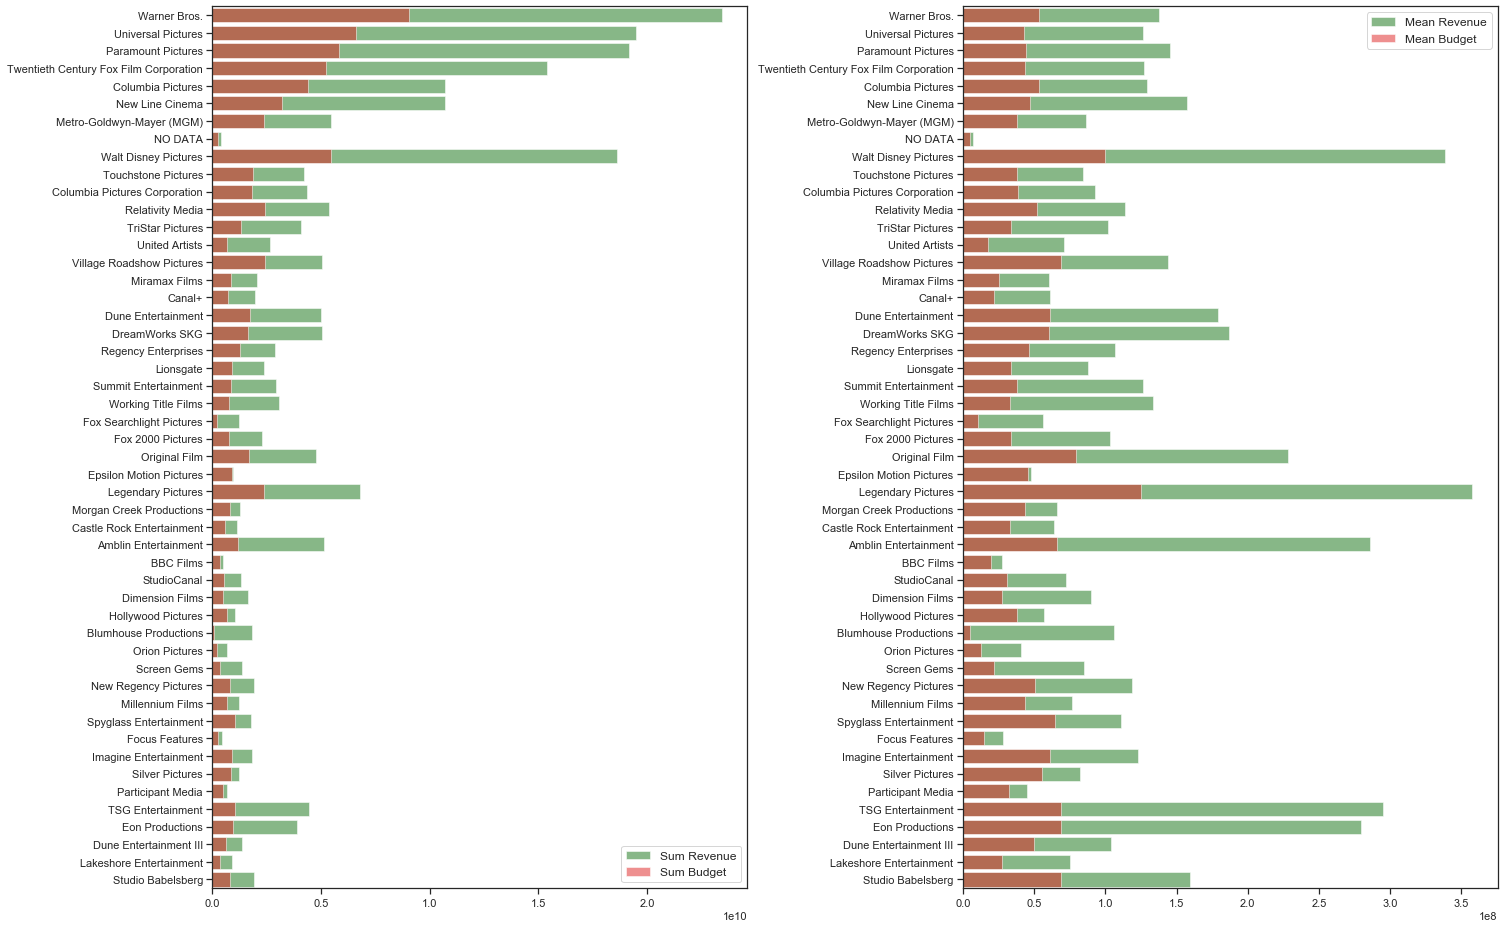

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 13), sharex=False)
ax1, ax2 = axes

barplot_movies("production_companies", agg="sum", ax=ax1, top=50)
barplot_movies("production_companies", agg="mean", ax=ax2, top=50)

# production_company_names, production_company_budgets, production_company_revenues, production_company_nets = box_office_from_search("production_companies", top=50)

# sns.set_color_codes("pastel")
# sns.barplot(x=production_company_revenues, y=list(range(50)), orient="h", ax=ax, label="Total Revenue", color="g")
# sns.set_color_codes("muted")
# sns.barplot(x=production_company_budgets, y=list(range(50)), orient="h", ax=ax, label="Total Budget", color="g")

# ax.legend()
# ax.set_yticklabels(production_company_names)

plt.tight_layout()

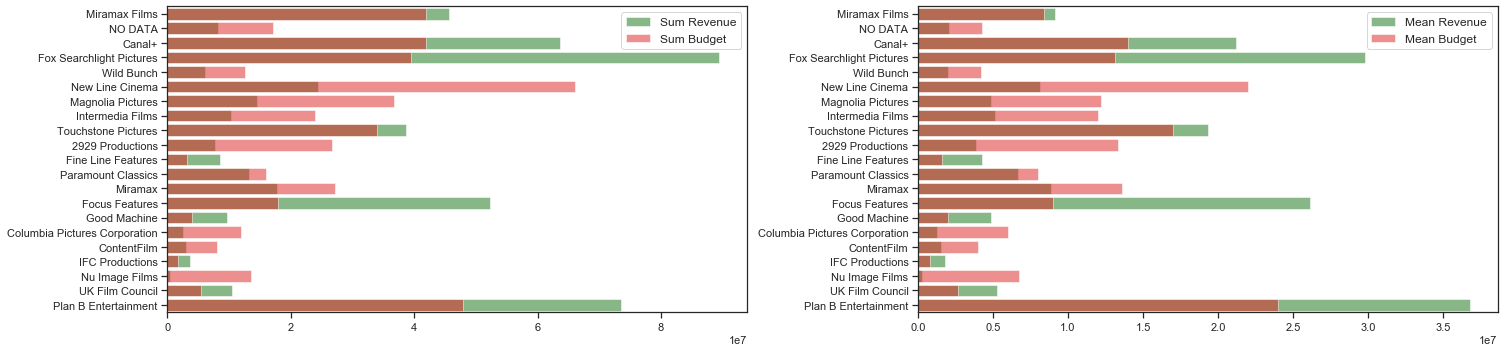

In [31]:
indie_df = movie_search(train_df, "independent film", "Keywords")

indie_counts_df = count_dict_items(indie_df)
# len(indie_counts_df["production_companies"].dropna())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 5), sharex=False)

barplot_movies("production_companies", agg="sum", ax=ax1, df=indie_df, data_to_find=indie_counts_df)
barplot_movies("production_companies", agg="mean", ax=ax2, df=indie_df, data_to_find=indie_counts_df)


# indie_company_names, indie_company_budgets, indie_company_revenues, indie_company_nets = box_office_from_search(
#     "production_companies", top=len(indie_counts_df["production_companies"].dropna()), df=indie_df, data_to_find=indie_counts_df)

# sns.set_color_codes("colorblind")
# sns.barplot(x=indie_company_revenues, y=list(range(len(indie_company_nets))), orient="h", ax=ax, alpha=0.5, color="green", label="Total Revenue")
# sns.set_color_codes("colorblind")
# sns.barplot(x=indie_company_budgets, y=list(range(len(indie_company_nets))), orient="h", ax=ax, alpha=0.5, color="red", label="Total Budget")

# ax.set_yticklabels(indie_company_names)
# ax.legend()
# ax.set_title("Revenues & Budgets of Production Companies for Independent Films", fontsize="xx-large")

plt.tight_layout()

In [32]:
# indie_counts_df.head(21)

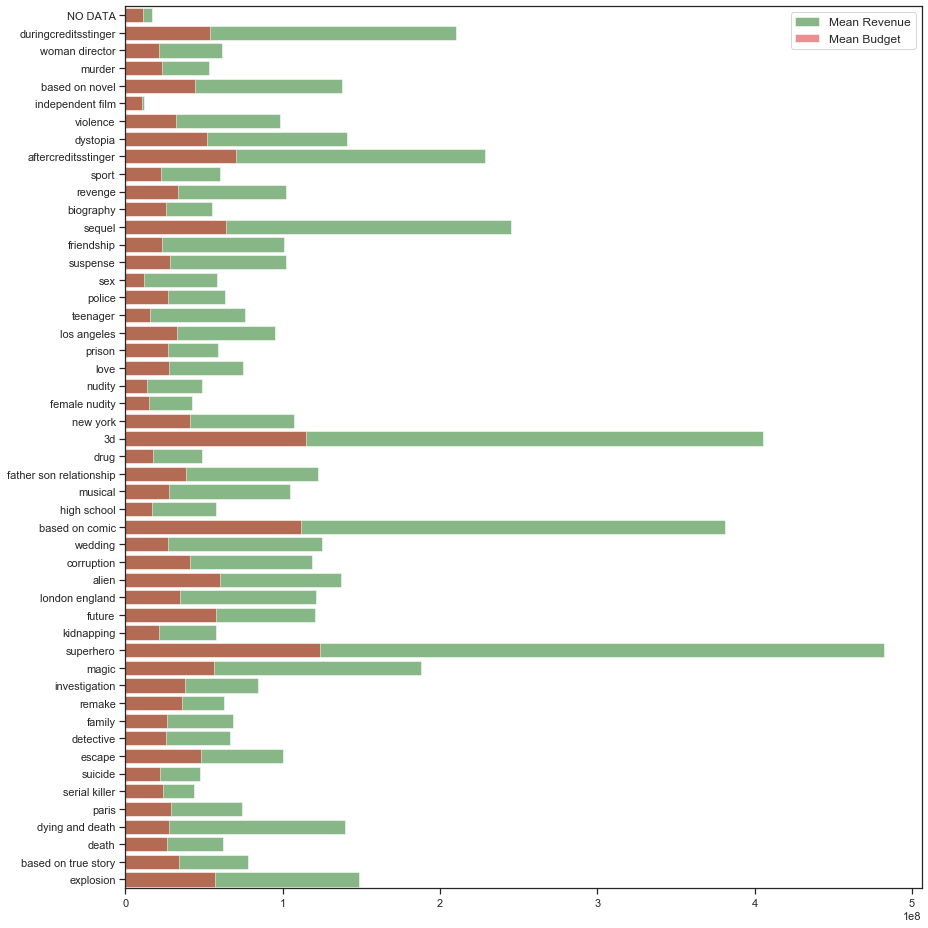

In [33]:
fig, ax = plt.subplots(figsize=(13,13))

barplot_movies("Keywords", agg="mean", top=50, ax=ax)

plt.tight_layout()

In [34]:
# train_df.sort_values("popularity", ascending=False)

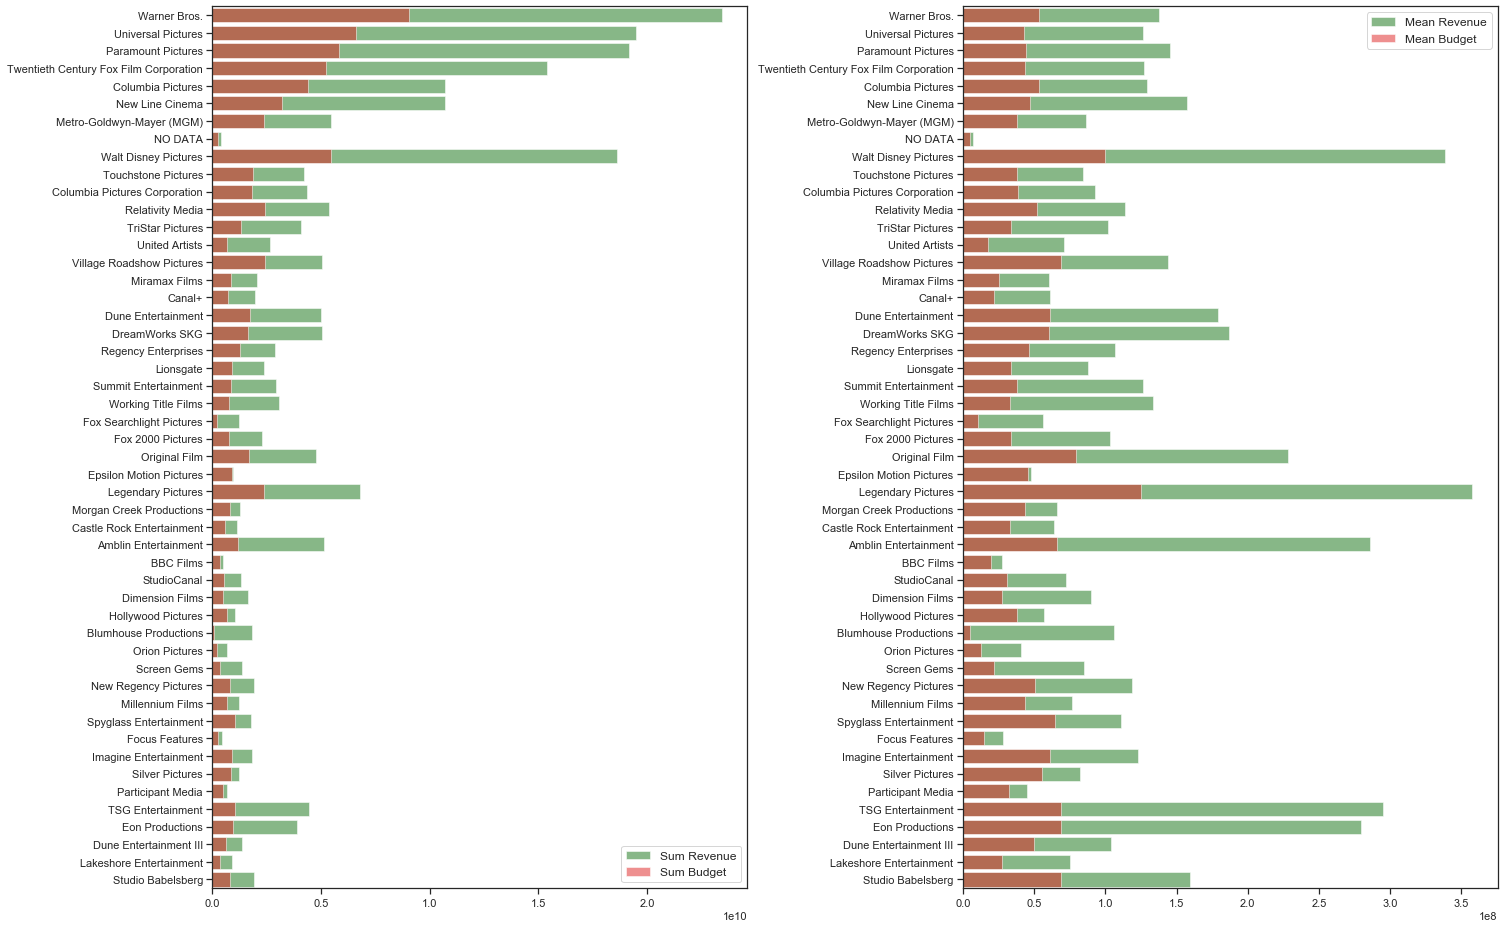

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,13))

barplot_movies("production_companies", agg="sum", ax=ax1, top=50)
barplot_movies("production_companies", agg="mean", ax=ax2, top=50)

plt.tight_layout()

In [36]:
# movie_search(train_df, "legendary pictures", "production_companies").sort_values("adjusted_roi", ascending=False).head()

### Hypothesis

H<sub>0</sub>: There is no difference in the return on investment with either a Comedy or a Drama.

H<sub>a</sub>: It is more likely to make at least 2x the budget in revenue with a Comedy than a Drama.

##### otherwise:

H<sub>0</sub>: comedy μ = drama μ

H<sub>a</sub>: comedy μ > drama μ

###### where μ is the average adjusted return on investment (revenue/2xbudget)

$H_0$: Comedy adjusted roi is equaliy likely to be higher than Drama as the other way around.  I.e.

$P(\text{Adjusted Comedy ROI} > \text{Adjusted Drama ROI}) = 0.5$

α = 0.01

In [37]:
def count_winning_pairs(sample_1, sample_2):
    sample_1, sample_2 = np.array(sample_1), np.array(sample_2)
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

In [38]:
def dataframe_dictionary(category):
    dfs = {}
    for ele, _ in top_counts_df[category].dropna():
        ele = ele.lower()
        dfs[ele] = movie_search(train_df, ele, category)
    return dfs

In [72]:
# genres, _, _, _ = box_office_from_search("genres", agg="mean")

genre_dfs = dataframe_dictionary("genres")
genre_p_vals = {}

# for genre in genres:
#     genre = genre.lower()
#     genre_dfs[genre] = movie_search(train_df, genre, "genres")

# drama_df = movie_search(train_df, "drama", "genres")
# comedy_df = movie_search(train_df, "comedy", "genres")
# thriller_df = movie_search(train_df, "thriller", "genres")
# action_df = movie_search(train_df, "action", "genres")

significance_level = 0.01

for genre, genre_df in genre_dfs.items():
    for genre2, genre_df2 in genre_dfs.items():
        if genre == genre2:
            continue
#         print(f'p-value for {k2} > {k}:\t\t{stats.mannwhitneyu(genre_df["adjusted_roi"], genre_df2["adjusted_roi"], alternative="greater").pvalue:2.3f}')
        greater_mannwhitneyu_pvalue = stats.mannwhitneyu(genre_df["adjusted_roi"],
                                                         genre_df2["adjusted_roi"],
                                                         alternative="greater").pvalue
        if greater_mannwhitneyu_pvalue < significance_level:
            greater_mannwhitneyu_null = "reject the null hypothesis"
        elif greater_mannwhitneyu_pvalue >= significance_level:
            greater_mannwhitneyu_null = "fail to reject the null hypothesis"
            
        less_mannwhitneyu_pvalue = stats.mannwhitneyu(genre_df["adjusted_roi"],
                                                      genre_df2["adjusted_roi"],
                                                      alternative="less").pvalue
        if less_mannwhitneyu_pvalue > 1-significance_level:
            less_mannwhitneyu_null = "reject the null hypothesis"
        elif less_mannwhitneyu_pvalue <= 1-significance_level:
            less_mannwhitneyu_null = "fail to reject the null hypothesis"
            
        genre_p_vals[f"{genre2} > {genre}"] = greater_mannwhitneyu_pvalue, greater_mannwhitneyu_null
        genre_p_vals[f"{genre2} < {genre}"] = less_mannwhitneyu_pvalue, less_mannwhitneyu_null

# stats.mannwhitneyu(genre_dfs["drama"]["adjusted_roi"], genre_dfs["comedy"]["adjusted_roi"], alternative="greater")

In [73]:
genre_p_vals["drama < romance"]

(0.9943692560176327, 'reject the null hypothesis')

In [41]:
production_company_dfs = dataframe_dictionary("production_companies")
# for production_company, _ in top_counts_df["production_companies"].dropna():
#     production_company = production_company.lower()
#     production_company_dfs = movie_search(train_df, production_company, "production_companies")

In [42]:
movie_search(production_company_dfs["warner bros."], "comedy", "genres")["adjusted_roi"].describe()

count    50.000000
mean      1.904352
std       3.369400
min       0.068084
25%       0.637578
50%       1.066744
75%       1.673236
max      22.980769
Name: adjusted_roi, dtype: float64

In [43]:
for production_company, _ in top_counts_df["production_companies"][:4]:
    print(production_company)
    print(production_company_dfs[production_company.lower()]["adjusted_roi"].describe())
    print()

Warner Bros.
count    170.000000
mean       1.883417
std        3.387399
min        0.011312
25%        0.538626
50%        1.068176
75%        1.768295
max       27.581634
Name: adjusted_roi, dtype: float64

Universal Pictures
count    154.000000
mean       2.208198
std        3.811082
min        0.018693
25%        0.603666
50%        1.204765
75%        2.179037
max       33.618143
Name: adjusted_roi, dtype: float64

Paramount Pictures
count    132.000000
mean       3.010492
std        6.252972
min        0.041893
25%        0.573538
50%        1.336670
75%        2.696878
max       54.322365
Name: adjusted_roi, dtype: float64

Twentieth Century Fox Film Corporation
count    121.000000
mean       2.349109
std        5.069554
min        0.008255
25%        0.699907
50%        1.243543
75%        2.142857
max       47.038466
Name: adjusted_roi, dtype: float64



In [44]:
production_company_p_vals = {}
significance_level = 0.05

for production_company, _ in top_counts_df["production_companies"][:4]:
    for production_company2, __ in top_counts_df["production_companies"][:4]:
        if production_company == production_company2:
            continue
        greater_mannwhitneyu_pvalue = stats.mannwhitneyu(production_company_dfs[production_company.lower()]["adjusted_roi"],
                                                         production_company_dfs[production_company2.lower()]["adjusted_roi"],
                                                         alternative="greater").pvalue
        if greater_mannwhitneyu_pvalue < significance_level:
            greater_mannwhitneyu_null = "REJECT the null hypothesis"
        elif greater_mannwhitneyu_pvalue >= significance_level:
            greater_mannwhitneyu_null = "FAIL to reject the null hypothesis"
            
        less_mannwhitneyu_pvalue = stats.mannwhitneyu(production_company_dfs[production_company.lower()]["adjusted_roi"],
                                                      production_company_dfs[production_company2.lower()]["adjusted_roi"],
                                                      alternative="less").pvalue
        if less_mannwhitneyu_pvalue > 1-significance_level:
            less_mannwhitneyu_null = "REJECT the null hypothesis"
        elif less_mannwhitneyu_pvalue <= 1-significance_level:
            less_mannwhitneyu_null = "FAIL to reject the null hypothesis"
            
        production_company_p_vals[f"{production_company2} > {production_company}"] = greater_mannwhitneyu_pvalue, greater_mannwhitneyu_null
        production_company_p_vals[f"{production_company2} < {production_company}"] = less_mannwhitneyu_pvalue, less_mannwhitneyu_null

#     print(f"{production_company} Adjusted ROI for Comedy")
#     print(movie_search(production_company_dfs[production_company.lower()], "comedy", "genres")["adjusted_roi"].describe())
#     print(f"{production_company} Adjusted ROI for Drama")
#     print(movie_search(production_company_dfs[production_company.lower()], "drama", "genres")["adjusted_roi"].describe())
#     print()

In [45]:
for companies, val in production_company_p_vals.items():
    print(companies, val)
    print()

Universal Pictures > Warner Bros. (0.9417216252578015, 'FAIL to reject the null hypothesis')

Universal Pictures < Warner Bros. (0.058416778367974646, 'FAIL to reject the null hypothesis')

Paramount Pictures > Warner Bros. (0.9736234920255751, 'FAIL to reject the null hypothesis')

Paramount Pictures < Warner Bros. (0.026457819091269066, 'FAIL to reject the null hypothesis')

Twentieth Century Fox Film Corporation > Warner Bros. (0.9612522031686448, 'FAIL to reject the null hypothesis')

Twentieth Century Fox Film Corporation < Warner Bros. (0.03886663621839529, 'FAIL to reject the null hypothesis')

Warner Bros. > Universal Pictures (0.058416778367974646, 'FAIL to reject the null hypothesis')

Warner Bros. < Universal Pictures (0.9417216252578015, 'FAIL to reject the null hypothesis')

Paramount Pictures > Universal Pictures (0.7051428588288828, 'FAIL to reject the null hypothesis')

Paramount Pictures < Universal Pictures (0.2953520621613441, 'FAIL to reject the null hypothesis')

T

In [46]:
# romance_df = movie_search(train_df, "romance", "genres")
# science_fiction_df = movie_search(train_df, "science fiction", "genres")
# horror_df = movie_search(train_df, "horror", "genres")

# stats.mannwhitneyu(romance_df["adjusted_roi"], horror_df["adjusted_roi"], alternative="greater")

In [47]:
# def welch_test_statistic(sample_1, sample_2):
#     numerator = np.mean(sample_1) - np.mean(sample_2)
#     denominator = np.sqrt((np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2)))
#     return numerator / denominator

# welch_test_statistic(drama_df["adjusted_roi"], comedy_df["adjusted_roi"])

In [48]:
print(f"std of sampling distribution: {148.027640/2091**0.5}")
train_df["adjusted_roi"].describe()

std of sampling distribution: 3.2371721755124194


count    2091.000000
mean        6.272967
std       148.027640
min         0.002582
25%         0.441354
50%         1.040932
75%         2.105924
max      6445.193333
Name: adjusted_roi, dtype: float64

In [49]:
print(f"std of sampling distribution: {5.666494/1031**0.5}")
movie_search(train_df, "drama", "genres")["adjusted_roi"].describe()

std of sampling distribution: 0.17647577614365473


count    1031.000000
mean        2.175868
std         5.666494
min         0.003012
25%         0.363853
50%         0.869996
75%         1.964941
max       110.000000
Name: adjusted_roi, dtype: float64

In [50]:
print(f"std of sampling distribution: {4.109138/696**0.5}")
movie_search(train_df, "comedy", "genres")["adjusted_roi"].describe()

std of sampling distribution: 0.1557564739297864


count    696.000000
mean       2.022508
std        4.109138
min        0.005881
25%        0.482263
50%        1.077256
75%        2.125331
max       58.354259
Name: adjusted_roi, dtype: float64

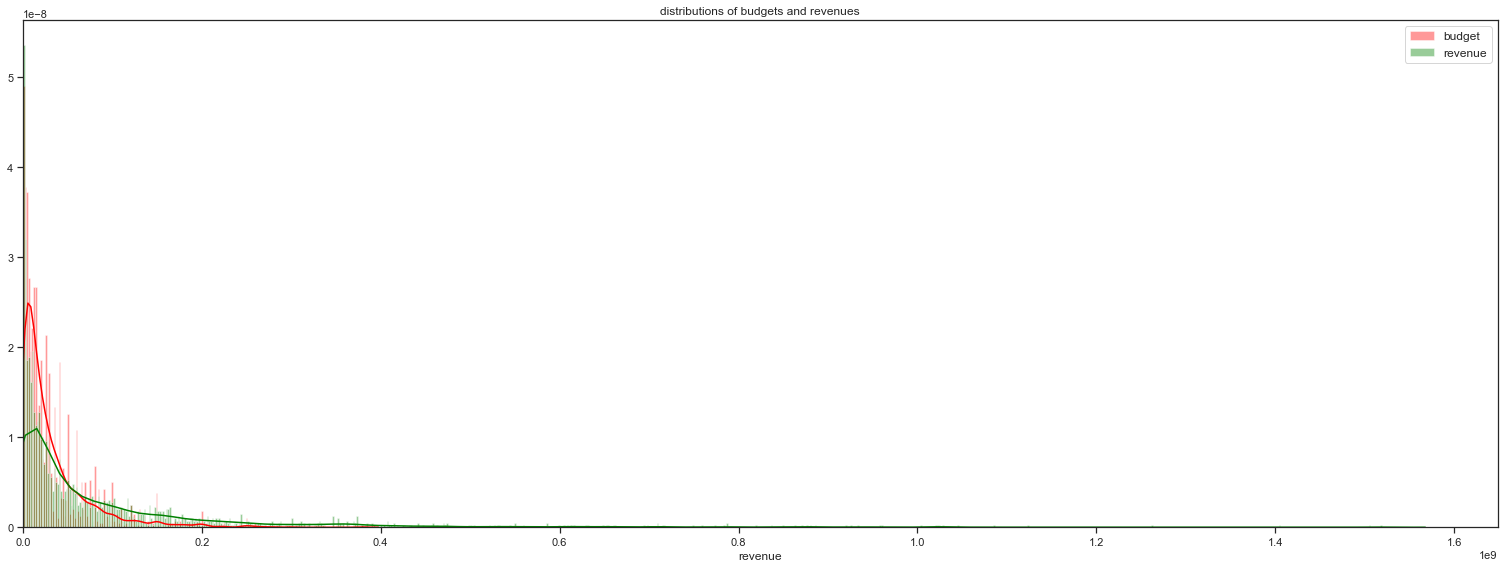

In [51]:
fig, ax = plt.subplots(figsize=(21,8))

sns.set_color_codes("colorblind")
sns.distplot(train_df["budget"], ax=ax, bins=200, label="budget", color="red")
sns.distplot(train_df["revenue"], ax=ax, bins=800, label="revenue", color="green")

ax.set_xlim(0)
# ax.set_ylim(0, 0.00001)

ax.legend(fontsize="large")
ax.set_title("distributions of budgets and revenues", fontsize="large")

plt.tight_layout()

In [52]:
successful_movies = (train_df["adjusted_roi"] > 1).sum()
num_of_samples = len(train_df["adjusted_roi"])

print("percent of movies in dataset that make at least twice as much revenue than budget spent:")
(successful_movies / num_of_samples)

percent of movies in dataset that make at least twice as much revenue than budget spent:


0.5155428024868484

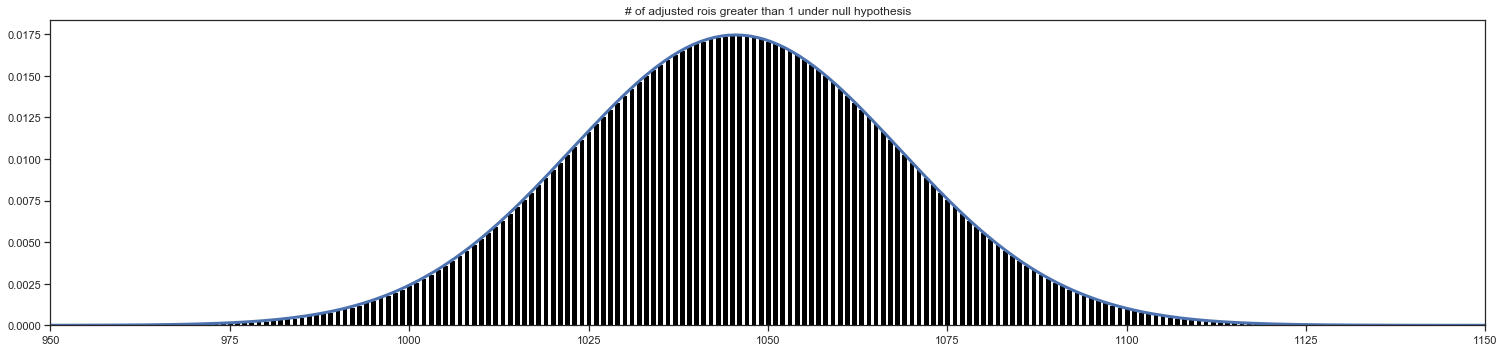

In [53]:
binomial = stats.binom(n=num_of_samples, p=0.50)
binomial_mean = 0.5 * num_of_samples
binomial_var = num_of_samples * 0.5 * 0.5
normal_approx = stats.norm(binomial_mean, np.sqrt(binomial_var))

x = np.linspace(0, num_of_samples, num=num_of_samples)

fig, ax = plt.subplots(figsize=(21, 5))

bar_sizes = [binomial.pmf(i) for i in range(num_of_samples+1)]
bars = ax.bar(range(num_of_samples+1), bar_sizes, color="black", align="center")

ax.set_title("# of adjusted rois greater than 1 under null hypothesis", fontsize="large")

ax.plot(x, normal_approx.pdf(x), linewidth=3)
ax.set_xlim(950, 1150)

plt.tight_layout()

In [54]:
p_value = 1 - normal_approx.cdf((train_df["adjusted_roi"] > 1).sum() - 0.5)
print("p-value for dataset:")
p_value

p-value for dataset:


0.08081703831494447

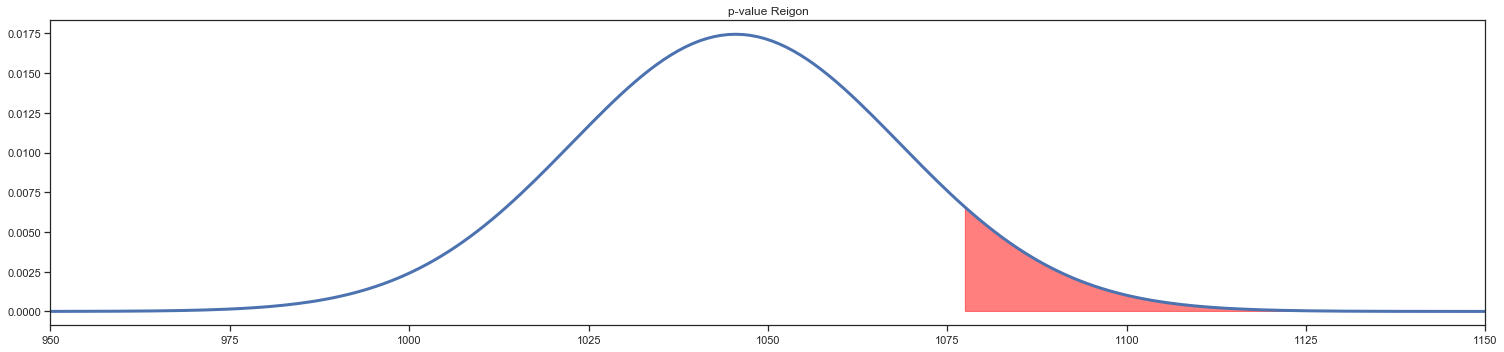

In [55]:
fig, ax = plt.subplots(1, figsize=(21, 5))

ax.plot(x, normal_approx.pdf(x), linewidth=3)
ax.set_xlim(950, 1150)
ax.fill_between(x, normal_approx.pdf(x), 
                where=(x >= successful_movies-1), color="red", alpha=0.5)
ax.set_title("p-value Reigon", fontsize="large")

plt.tight_layout()

In [56]:
1 - 0.08081703831494447

0.9191829616850555